In [1]:
%pip install spacy transformers 

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install nltk pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install 'tensorflow[and-cuda]'

Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings

warnings.filterwarnings('ignore')
import math 
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from keras.optimizers import Adam

2024-01-22 12:17:23.907333: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-22 12:17:24.037210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 12:17:24.037266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 12:17:24.055940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 12:17:24.097348: I tensorflow/core/platform/cpu_feature_guar

In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-22 12:17:26.947678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 12:17:27.013160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 12:17:27.013324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
data_train = pd.read_csv('dados_treino.txt', header=None, delimiter=';')
data_test = pd.read_csv('dados_teste.txt', header=None, delimiter=';')

In [8]:
data_train.rename(columns={0: 'text', 1: 'sentiment'}, inplace=True)
data_test.rename(columns={0: 'text', 1: 'sentiment'}, inplace=True)

In [9]:
print('shape train data: {}\nshape test data: {}'.format(data_train.shape, data_test.shape))

shape train data: (16000, 2)
shape test data: (2000, 2)


In [10]:
data_train.head()

,text,sentiment
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [11]:
data_test.head()

,text,sentiment
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [12]:
data_train['sentiment'].value_counts()

sentiment
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [13]:
data_test['sentiment'].value_counts()

sentiment
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [14]:
%python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [15]:
nlp = spacy.load('en_core_web_md')

In [16]:
def process_text(text: str) -> str:
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [17]:
data_train['processed_text'] = data_train['text'].apply(process_text)

In [18]:
data_train.head()

,text,sentiment,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [19]:
data_test['processed_text'] = data_test['text'].apply(process_text)

In [20]:
data_test.head()

,text,sentiment,processed_text
0,i feel like my only role now would be to tear ...,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each ot...,anger,feel bcoz fight mad n u wanna publicity n let ...
2,i feel like reds and purples are just so rich ...,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go a...,sadness,m sure feeling loss away dull sweet feeling no...
4,i feel like ive gotten to know many of you thr...,joy,feel like ve get know comment email m apprecia...


In [21]:
tf_idf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')

In [22]:
tfidf_train = tf_idf.fit_transform(data_train['processed_text'])
tfidf_test = tf_idf.transform(data_test['processed_text'])

In [23]:
print(f"shape training data: {tfidf_train.shape}\nshape test data: {tfidf_test.shape}")

shape training data: (16000, 5586)
shape test data: (2000, 5586)


In [24]:
X_train = tfidf_train.toarray()
X_test = tfidf_test.toarray()

AAAAAAAAAA

In [25]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(data_train['sentiment'])
y_test = label_encoder.transform(data_test['sentiment'])

In [26]:
weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

type(weights)

numpy.ndarray

In [27]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, 
                                                            y_train,
                                                            test_size = 0.2, 
                                                            random_state = 42, 
                                                            stratify=y_train)

y_training_encoded = to_categorical(y_training)
y_valid_encoded = to_categorical(y_valid)
y_test_encoded = to_categorical(y_test)


In [28]:
print(y_training, y_training_encoded)
type(y_training_encoded)

[4 2 2 ... 4 2 2] [[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


numpy.ndarray

In [29]:
activation, initializer, input_shape, regularizer = 'selu', 'lecun_normal', (X_training.shape[1],), keras.regularizers.l2(0.01)
regularizer_2 = keras.regularizers.l2(0.1)

In [30]:
ffcn = Sequential([
    Dense(4096, 
          activation=activation,
          kernel_initializer=initializer, 
          input_shape=(input_shape),
          kernel_regularizer=regularizer
          ),
    Dense(2048, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer
          ),
    Dense(1024, 
          activation=activation,
          kernel_initializer=initializer, 
          kernel_regularizer=regularizer_2
          ),
    Dense(64, activation=activation),
    Dense(6, activation='softmax')
])

2024-01-22 12:18:57.077424: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 12:18:57.077664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 12:18:57.077774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [31]:
ffcn.layers[-1].bias.assign(weights)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [32]:
ffcn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
ffcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              22884352  
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33439174 (127.56 MB)
Trainable params: 33439174 (127.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
l_rate_0 = 0.001
drop = 0.5
epochs_drop = 10

lr_scheduler = LearningRateScheduler(lambda epoch: l_rate_0 * math.pow(drop, math.floor(((1+ epoch) / epochs_drop))))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [35]:
epochs = 20
batch_size = 256

In [36]:
%%time
history = ffcn.fit(X_training,
                   y_training_encoded,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(X_valid, y_valid_encoded),
                   callbacks=[early_stopping, lr_scheduler]
                   )

Epoch 1/20


2024-01-22 12:19:00.312193: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-22 12:19:00.377007: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f994d7d3c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 12:19:00.377024: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-22 12:19:00.385644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-22 12:19:00.658028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1705936740.727277  126980 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 4s 29ms/step - loss: 37.0294 - accuracy: 0.6713 - val_loss: 2.2586 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 21ms/step - loss: 1.4884 - accuracy: 0.7979 - val_loss: 1.3278 - val_accuracy: 0.8019 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 1s 21ms/step - loss: 1.2080 - accuracy: 0.8197 - val_loss: 1.2088 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 24ms/step - loss: 1.0677 - accuracy: 0.8505 - val_loss: 1.1352 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 1s 21ms/step - loss: 0.9608 - accuracy: 0.8712 - val_loss: 1.0864 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 1s 20ms/step - loss: 0.9169 - accuracy: 0.8862 - val_loss: 1.0726 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 1s 18ms/step - loss: 0.8565 - accu

In [39]:
loss, val_loss = history.history['loss'], history.history['val_loss']

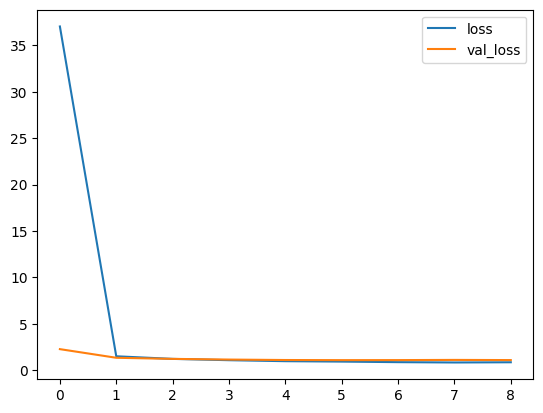

In [40]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [41]:
predict_v1 = ffcn.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [43]:
predict_v1.argmax(axis=1)

array([4, 0, 2, ..., 2, 2, 5])

In [48]:
report = classification_report(y_test, predict_v1.argmax(axis=1), output_dict=True)

In [51]:
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.865613,0.796364,0.829545,275.000
1,0.869822,0.656250,0.748092,224.000
2,0.866758,0.907914,0.886859,695.000
3,0.666667,0.704403,0.685015,159.000
4,0.843800,0.901893,0.871880,581.000
5,0.672131,0.621212,0.645669,66.000
accuracy,0.837000,0.837000,0.837000,0.837
macro avg,0.797465,0.764673,0.777843,2000.000
weighted avg,0.837945,0.837000,0.835079,2000.000


In [52]:
ffcn.save('first_model_v1.keras')

In [57]:
frase = 'I am stronger than ever'

exemplo = pd.DataFrame({'Frase': [frase]})

exemplo_model = tf_idf.transform(exemplo['Frase']).toarray()

exemplo_model

array([[0., 0., 0., ..., 0., 0., 0.]])

In [58]:
label_encoder.inverse_transform(ffcn.predict(exemplo_model).argmax(axis=1))

1/1 [==============================] - 0s 16ms/step


array(['joy'], dtype=object)